In [2]:
import os
from PIL import Image
import pydicom
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from tqdm import tqdm
import pandas as pd
import numpy as np

In [ ]:
class MixedImageDataset(Dataset):
    def __init__(self, root_dir, transform=None, to_rgb=True):
        self.root_dir = root_dir
        self.transform = transform if transform else transforms.ToTensor()
        self.to_rgb = to_rgb  # convert grayscale DICOM → 3-channel if True

        # Collect all files recursively
        self.files = []
        for subdir, _, filenames in os.walk(root_dir):
            for f in filenames:
                if f.lower().endswith((".png", ".jpg", ".jpeg", ".dcm")):
                    self.files.append(os.path.join(subdir, f))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        filepath = self.files[idx]

        # --- PNG / JPG ---
        if filepath.lower().endswith((".png", ".jpg", ".jpeg")):
            img = Image.open(filepath).convert("RGB")  
            img = self.transform(img)

        # --- DICOM ---
        elif filepath.lower().endswith(".dcm"):
            dicom = pydicom.dcmread(filepath)
            img_array = dicom.pixel_array.astype("float32")

            # normalize [0,1]
            img_array = img_array / img_array.max() if img_array.max() > 0 else img_array
            img = torch.tensor(img_array).unsqueeze(0)  # shape: [1, H, W]

            if self.to_rgb:  # make 3-channel to match PNG/JPG
                img = img.repeat(3, 1, 1)

            # Apply same transforms (convert back to PIL first if needed)
            if self.transform:
                img = self.transform(transforms.ToPILImage()(img))

        else:
            raise ValueError(f"Unsupported file format: {filepath}")

        return img

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # resize all images to same size
    transforms.ToTensor()
])

dataset = MixedImageDataset("Input", transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Iterate through batches
for batch in dataloader:
    print(batch.shape)  # [B, C, H, W]
    break

In [ ]:
import matplotlib.pyplot as plt

batch = next(iter(dataloader))

plt.figure(figsize=(10, 5))
plt.tight_layout()
for i in range(len(dataset)):
    img = dataset[i].permute(1, 2, 0).numpy()  # convert [C,H,W] → [H,W,C]
    plt.subplot(3, int(len(dataset)/3), i+1)
    plt.imshow(img)
    # plt.title(os.path.basename(paths[i]))
    plt.axis("off")

plt.show()

In [3]:
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, img_root, transform=None, to_rgb=True):
        """
        csv_file: path to CSV containing [path, label] columns
        img_root: folder where images are stored
        """
        self.data = pd.read_csv(csv_file)
        self.img_root = img_root
        self.transform = transform if transform else transforms.ToTensor()
        self.to_rgb = to_rgb
        self.label_map = {label: idx for idx, label in enumerate(self.data.iloc[:,1].unique())}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        rel_path = self.data.iloc[idx, 0]   # image path (relative or full)
        label = self.data.iloc[idx, 1] # label
        # label = self.label_map[label_str]

        filepath = os.path.join(self.img_root, rel_path)

        # --- PNG / JPG ---
        if filepath.lower().endswith((".png", ".jpg", ".jpeg")):
            img = Image.open(filepath).convert("RGB")
            img_tensor = self.transform(img)

        # --- DICOM ---
        elif filepath.lower().endswith(".dcm"):
            dicom = pydicom.dcmread(filepath)
            img_array = dicom.pixel_array.astype("float32")
            img_array = img_array / img_array.max() if img_array.max() > 0 else img_array
            img_tensor = torch.tensor(img_array).unsqueeze(0)  # [1,H,W]

            if self.to_rgb:
                img_tensor = img_tensor.repeat(3, 1, 1)

            if self.transform:
                img_tensor = self.transform(transforms.ToPILImage()(img_tensor))

        else:
            raise ValueError(f"Unsupported file format: {filepath}")

        return img_tensor.float(), torch.tensor(label, dtype=torch.float)


In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Training dataset
train_dataset = CustomImageDataset(
    csv_file="./data/XPAge01_RGB/testdata.csv",
    img_root="./data/XPAge01_RGB/JPGs",
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Testing dataset
# test_dataset = CustomImageDataset(
#     csv_file="XPAge01_RGB/XP/trainingdata.csv",
#     img_root="XPAge01_RGB/XP/JPGs",
#     transform=transform
# )

# test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [12]:
import matplotlib.pyplot as plt

img_tensor, label = train_dataset[1]
# [C,H,W] → [H,W,C]
# img = img_tensor.permute(1, 2, 0).numpy()
img_tensor.min()
# plt.imshow(img)
# plt.title(f"Label: {label}")
# plt.axis("off")
# plt.show()

tensor(0.)

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
import torchvision.models as models
import torch.nn as nn
# Choose model (either resnet18 or resnet50)
model = models.resnet18(weights=None)   # or models.resnet50(pretrained=False)

# Change final fully-connected layer for 10 MNIST classes
# model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)

model = model.to(device)

In [ ]:
loss_func = nn.L1Loss().to(device)
loss_func
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
optimizer

In [ ]:
num_epochs = 60
def train(num_epochs, model, loader):
    # Train the model
    model.train()
    total_step = len(loader)
    for epoch in range(num_epochs):
        epoch_loss = 0
        # batch_bar = tqdm(loader, desc=f"Batches", leave=False)
        for i, (images, labels) in enumerate(loader):
            images, labels = images.to(device), labels.to(device)
            output = model(images).squeeze()
            loss = loss_func(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            # batch_bar.update(1)
            # batch_bar.set_postfix(loss=loss.item())

        # batch_bar.close()
        epoch_loss = epoch_loss/len(loader)
        print(f"Epoch {epoch+1} train loss: {epoch_loss}")

train(num_epochs, model, train_loader)

In [ ]:
model.eval()
correct = 0
total_mae = 0
n_samples =0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images).squeeze()
        print(outputs)
        # _, predicted = torch.max(outputs, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print(f"Test Accuracy: {100*correct/total:.2f}%")
        total_mae += torch.abs(outputs - labels).sum().item()
        n_samples += labels.size(0)
    
avg_mae = total_mae / n_samples
print(f"Test MAE: {avg_mae:.4f}")


In [86]:
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class ChestSegDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None, mask_transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.images = sorted(os.listdir(img_dir))
        self.masks = sorted(os.listdir(mask_dir))

        # pixel → class mapping
        self.class_map = {0: 0, 85: 1, 170: 2, 255: 3}

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        image = Image.open(img_path).convert("L")
        mask = Image.open(mask_path).convert("L")

        # Convert to numpy
        image = np.array(image, dtype=np.uint8)
        mask = np.array(mask, dtype=np.uint8)
    
        # Map labels (0, 85, 170, 255 → 0,1,2,3)
        mask_mapped = np.zeros_like(mask, dtype=np.uint8)
        mask_mapped[mask == 0] = 0
        mask_mapped[mask == 85] = 1
        mask_mapped[mask == 170] = 2
        mask_mapped[mask == 255] = 3
    
        # Apply transforms to image (still as PIL for torchvision)
        if self.transform:
            image = self.transform(Image.fromarray(image))
    
        # Handle mask directly as tensor
        mask_mapped = torch.from_numpy(mask_mapped).long()
    
        return image, mask_mapped


In [65]:
# Image transform (normalize grayscale)
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Mask transform (resize without interpolation!)
mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    # transforms.Normalize([0.5], [0.5])
])


In [87]:
# Image transform (normalize grayscale)
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Mask transform (resize without interpolation!)
mask_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST),
    # transforms.ToTensor(),
])


In [88]:
train_dataset = ChestSegDataset(
    img_dir="./data/Segmentation01/train/org",
    mask_dir="./data/Segmentation01/train/label",
    transform=image_transform,
    mask_transform=mask_transform
)

test_dataset = ChestSegDataset(
    img_dir="./data/Segmentation01/test/org",
    mask_dir="./data/Segmentation01/test/label",
    transform=image_transform,
    mask_transform=mask_transform
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


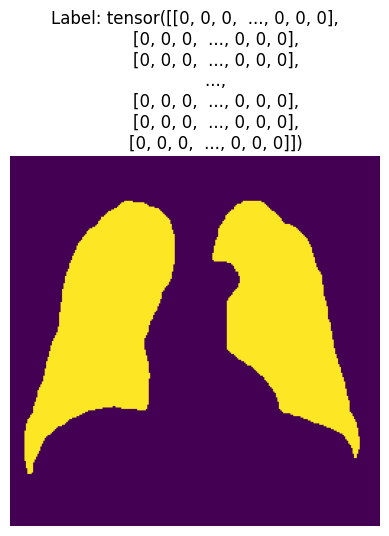

In [89]:
import matplotlib.pyplot as plt

img_tensor, label = train_dataset[1]
# [C,H,W] → [H,W,C]
img = label.permute(0, 1).numpy()

label.unique()

plt.imshow(img)
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()

In [70]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        
        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )
        
        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.middle = conv_block(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = conv_block(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = conv_block(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = conv_block(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        m = self.middle(self.pool(e4))

        d4 = self.up4(m)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        return self.final(d1)  # logits


In [90]:
criterion = nn.BCEWithLogitsLoss()
model = UNet(in_channels=1, out_channels=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

OutOfMemoryError: CUDA out of memory. Tried to allocate 36.00 MiB. GPU 0 has a total capacity of 4.00 GiB of which 0 bytes is free. Of the allocated memory 10.49 GiB is allocated by PyTorch, and 160.32 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [85]:
for epoch in range(100):
    model.train()
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)  # [B,1,H,W]
        print(outputs.shape, masks.squeeze(1).long().shape)
        loss = criterion(outputs, masks.squeeze(1).long())
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}: Loss={loss.item():.4f}")


OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU 0 has a total capacity of 4.00 GiB of which 0 bytes is free. Of the allocated memory 10.45 GiB is allocated by PyTorch, and 195.37 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [24]:
def dice_coefficient(preds, targets, eps=1e-6):
    # preds, targets are tensors [B,1,H,W] with 0/1 values
    preds = preds.view(-1)
    targets = targets.view(-1)

    intersection = (preds * targets).sum()
    dice = (2. * intersection + eps) / (preds.sum() + targets.sum() + eps)
    return dice.item()


In [25]:
model.eval()
dice_scores = []
with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float()
        dice = dice_coefficient(preds, masks)
        dice_scores.append(dice)

print("Average Dice:", sum(dice_scores) / len(dice_scores))


Average Dice: 4.0513774779427084e-09


In [26]:
import matplotlib.pyplot as plt

def show_results(model, dataloader, device, num_images=3):
    model.eval()
    images_shown = 0
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            outputs = model(images)
            
            # Convert logits → probabilities → binary mask
            preds = torch.sigmoid(outputs)
            preds = (preds > 0.1).float()

            for i in range(images.size(0)):
                if images_shown >= num_images:
                    return
                fig, ax = plt.subplots(1, 3, figsize=(12, 4))
                ax[0].imshow(images[i][0].cpu(), cmap="gray")
                ax[0].set_title("Input Image")
                ax[1].imshow(masks[i][0].cpu(), cmap="gray")
                ax[1].set_title("Ground Truth")
                ax[2].imshow(preds[i][0].cpu(), cmap="gray")
                ax[2].set_title("Prediction")
                for a in ax: a.axis("off")
                plt.show()
                images_shown += 1


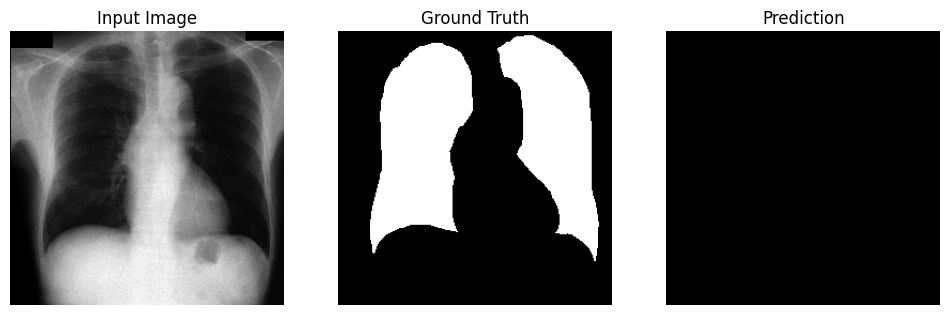

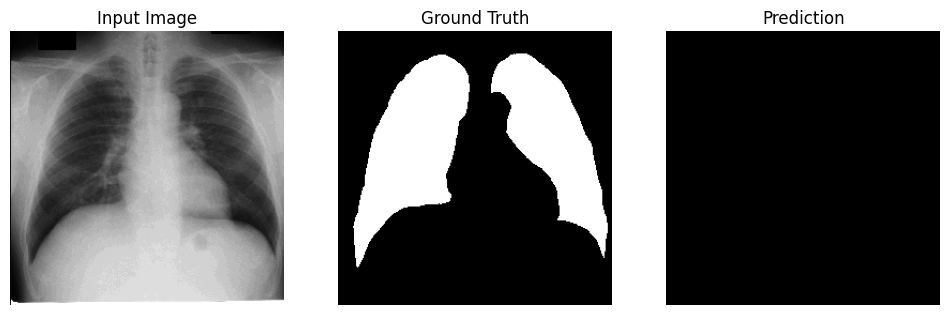

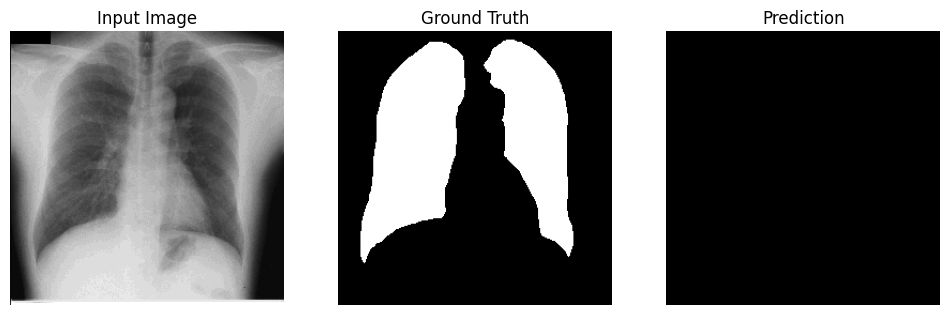

In [27]:
show_results(model, test_loader, device)

Segementation2

In [100]:
model2 = UNet(in_channels=1, out_channels=4).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)

In [102]:
for epoch in range(20):
    model2.train()
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)  # masks: [B,H,W]

        optimizer.zero_grad()
        outputs = model2(images)   # [B,4,H,W]
        loss = criterion(outputs, masks.squeeze(1).long())  # masks: [B,H,W]
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}: Loss={loss.item():.4f}")


Epoch 1: Loss=0.8140
Epoch 2: Loss=0.5691
Epoch 3: Loss=0.4233
Epoch 4: Loss=0.3198
Epoch 5: Loss=0.2471
Epoch 6: Loss=0.1953
Epoch 7: Loss=0.1603
Epoch 8: Loss=0.1294
Epoch 9: Loss=0.1069
Epoch 10: Loss=0.0901
Epoch 11: Loss=0.0778
Epoch 12: Loss=0.0647
Epoch 13: Loss=0.0565
Epoch 14: Loss=0.0498
Epoch 15: Loss=0.0447
Epoch 16: Loss=0.0396
Epoch 17: Loss=0.0360
Epoch 18: Loss=0.0326
Epoch 19: Loss=0.0305
Epoch 20: Loss=0.0276


In [ ]:
import torch

def multiclass_dice(preds, targets, num_classes=4, eps=1e-6):
    """
    preds: [B,H,W] (class indices from argmax)
    targets: [B,H,W] (ground truth class indices)
    """
    dice_scores = []
    for c in range(num_classes):
        pred_c = (preds == c).float()
        target_c = (targets == c).float()

        intersection = (pred_c * target_c).sum()
        dice = (2 * intersection + eps) / (pred_c.sum() + target_c.sum() + eps)
        dice_scores.append(dice.item())
    return dice_scores

In [105]:
model2.eval()
all_dice = []

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)

        outputs = model2(images)           # [B,4,H,W]
        preds = torch.argmax(outputs, 1)  # [B,H,W]

        dice_scores = multiclass_dice(preds, masks, num_classes=4)
        all_dice.append(dice_scores)

# Convert to tensor for easy averaging
all_dice = torch.tensor(all_dice)   # shape [num_batches, num_classes]
mean_dice_per_class = all_dice.mean(0)  # average across batches
overall_mean_dice = mean_dice_per_class.mean()

print("Dice per class:")
print(f"  Outside body:      {mean_dice_per_class[0]:.4f}")
print(f"  Heart:             {mean_dice_per_class[1]:.4f}")
print(f"  Outside lung:      {mean_dice_per_class[2]:.4f}")
print(f"  Lung field:        {mean_dice_per_class[3]:.4f}")
print(f"Overall mean Dice:   {overall_mean_dice:.4f}")


Dice per class:
  Outside body:      0.1405
  Heart:             1.0000
  Outside lung:      1.0000
  Lung field:        1.0000
Overall mean Dice:   0.7851


In [110]:
import matplotlib.pyplot as plt

colors = {
    0: (0,0,0),       # black = outside body
    1: (255,0,0),     # red = heart
    2: (0,255,0),     # green = outside lung
    3: (0,0,255)      # blue = lung
}

def decode_mask(mask):
    # print(mask.shape)
    b, h, w = mask.shape
    color_mask = np.zeros((h,w,3), dtype=np.uint8)
    for k, v in colors.items():
        color_mask[mask==k] = v
    return color_mask

def show_results_multi(model, dataloader, device, num_images=3):
    model.eval()
    shown = 0
    with torch.no_grad():
        for images, masks in dataloader:
            outputs = model(images.to(device))
            preds = torch.argmax(outputs, dim=1).cpu().numpy()

            for i in range(images.size(0)):
                if shown >= num_images:
                    return
                fig, ax = plt.subplots(1, 3, figsize=(12,4))
                ax[0].imshow(images[i][0].cpu(), cmap="gray")
                ax[0].set_title("Input Image")
                ax[1].imshow(decode_mask(masks[i].cpu().numpy()))
                ax[1].set_title("Ground Truth")
                ax[2].imshow(decode_mask(preds[i]))
                ax[2].set_title("Prediction")
                for a in ax: a.axis("off")
                plt.show()
                shown += 1


IndexError: boolean index did not match indexed array along axis 0; size of axis is 256 but size of corresponding boolean axis is 1

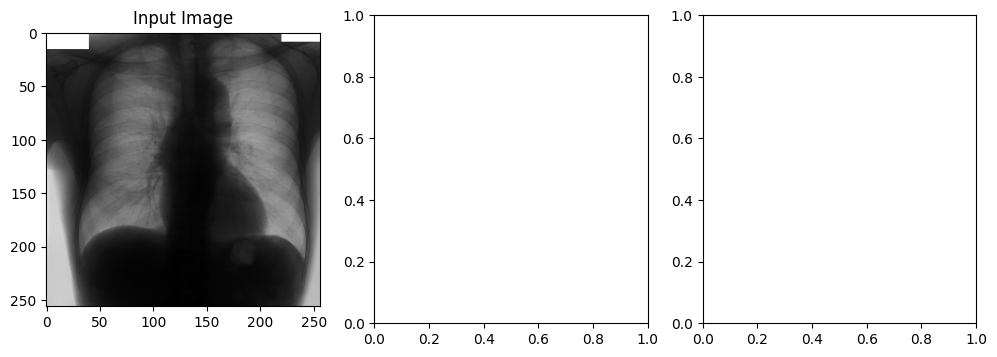

In [111]:
show_results_multi(model2, test_loader, device)

In [ ]:
import numpy as np

def mask_to_bbox(mask, class_id):
    """Extract bounding box from mask for a given class_id"""
    coords = np.argwhere(mask == class_id)
    if coords.size == 0:
        return None  # no object
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)
    return [x_min, y_min, x_max, y_max]

def lung_bboxes(mask, class_id=3):  # lung field = 255 → mapped to 3
    coords = np.argwhere(mask == class_id)
    if coords.size == 0:
        return []
    h, w = mask.shape
    mid_x = w // 2
    left = coords[coords[:,1] < mid_x]
    right = coords[coords[:,1] >= mid_x]
    boxes = []
    if left.size > 0:
        y_min, x_min = left.min(axis=0)
        y_max, x_max = left.max(axis=0)
        boxes.append([x_min, y_min, x_max, y_max])  # left lung
    if right.size > 0:
        y_min, x_min = right.min(axis=0)
        y_max, x_max = right.max(axis=0)
        boxes.append([x_min, y_min, x_max, y_max])  # right lung
    return boxes


In [124]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os

class ChestDetectionDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transforms=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transforms = transforms
        self.images = sorted(os.listdir(img_dir))
        self.masks = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        image = Image.open(img_path).convert("RGB")  # detection needs 3-channel
        mask = np.array(Image.open(mask_path).convert("L"))

        boxes = []
        labels = []

        # Heart (class_id = 1)
        heart_box = mask_to_bbox(mask, 1)  # assuming remapped 85 → 1
        if heart_box: 
            boxes.append(heart_box)
            labels.append(1)

        # Lungs (class_id = 2 for left, 3 for right)
        lung_boxes = lung_bboxes(mask, class_id=3)  # assuming 255 → 3
        if len(lung_boxes) == 2:
            boxes.append(lung_boxes[0]); labels.append(2)  # left
            boxes.append(lung_boxes[1]); labels.append(3)  # right

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels}

        if self.transforms:
            image = self.transforms(image)

        return image, target


In [125]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

num_classes = 4  # 0 = background, 1=heart, 2=left lung, 3=right lung
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)


C:\Users\sagar\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\sagar\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [127]:
train_dataset = ChestDetectionDataset("./segmentation02/segmentation/org_train_s", "./segmentation02/segmentation/label_train_s",
                                      transforms=transforms.ToTensor())
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

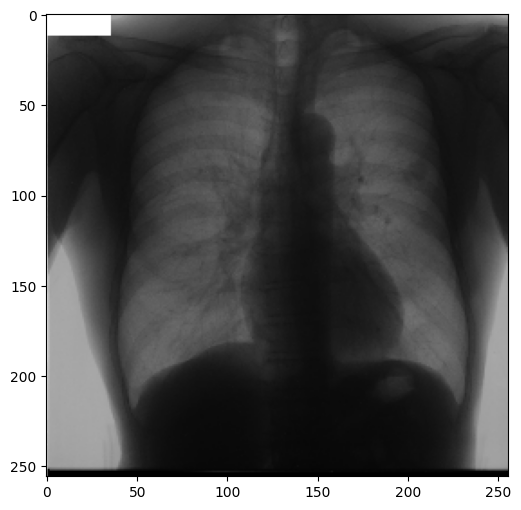

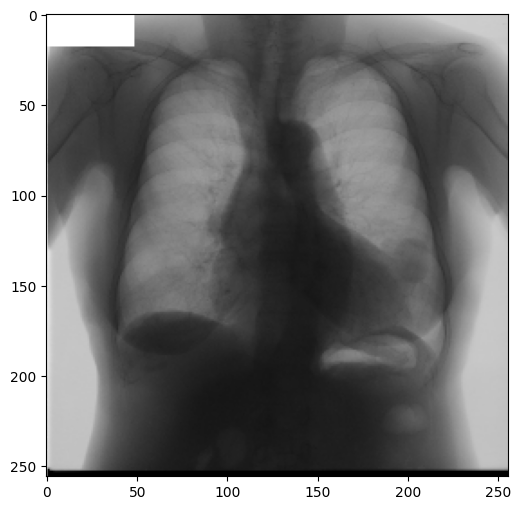

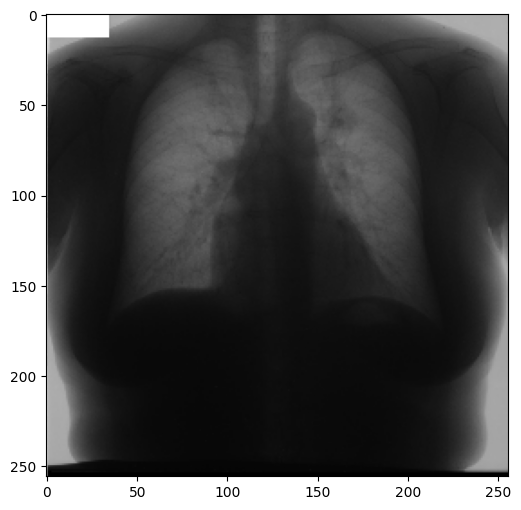

In [136]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

CLASS_NAMES = {1: "Heart", 2: "Left lung", 3: "Right lung"}

def show_detection_samples(dataset, num_samples=3):
    for i in range(num_samples):
        image, target = dataset[i]
        boxes, labels = target["boxes"], target["labels"]

        # Convert to numpy for plotting
        img = image.permute(1, 2, 0).cpu().numpy()
        if img.shape[2] == 1:  # grayscale → RGB
            img = np.repeat(img, 3, axis=2)

        fig, ax = plt.subplots(1, figsize=(6, 6))
        ax.imshow(img, cmap="gray")

        for box, label in zip(boxes, labels):
            x1, y1, x2, y2 = box.tolist()
            if x2 <= x1 or y2 <= y1:
                print(f"⚠️ Skipped invalid box: {box}")
                continue

            rect = patches.Rectangle(
                (x1, y1), x2 - x1, y2 - y1,
                linewidth=2, edgecolor="r", facecolor="none"
            )
            ax.add_patch(rect)
            label_name = CLASS_NAMES.get(label.item(), f"Class {label.item()}")
            ax.text(
                x1, y1 - 5, label_name,
                color="yellow", fontsize=10, backgroundcolor="black"
            )
        plt.show()
show_detection_samples(train_dataset, num_samples=3)

In [116]:
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=1e-4)

for epoch in range(10):
    model.train()
    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k,v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {losses.item():.4f}")


Epoch 1, Loss: 0.3987


KeyboardInterrupt: 